To fix the environment do these steps:
1. Cmd+shift+p
2. Select Interpreter
3. Copy and Paste: /Users/emafikre/venv/bin/python
4. Change kernal

In [1]:
import os
import sys
home = os.environ["HOME"]
sys.path.append(home+'/bin/python')

import problem_setup as p
import numpy as np
from mpl_toolkits.mplot3d import axes3d
from matplotlib import pyplot as plt
from matplotlib import cm
from radmc3dPy.image import *
from radmc3dPy.analyze import *
from radmc3dPy.natconst import *

import numpy as np

In [2]:
def diagnosis(dust):
    #
    print(dust)
    #
    # Some natural constants
    #
    au  = 1.49598e13    # Astronomical Unit       [cm]
    pc  = 3.08572e18     # Parsec                  [cm]
    ms  = 1.98892e33     # Solar mass              [g]
    ts  = 5.78e3         # Solar temperature       [K]
    ls  = 3.8525e33      # Solar luminosity        [erg/s]
    rs  = 6.96e10        # Solar radius            [cm]
    #
    # Monte Carlo parameters
    #
    nphot    = 1000000
    #
    # Grid parameters
    #
    nr       = 32
    ntheta   = 32
    nphi     = 1
    rin      = 10*au
    rout     = 100*au
    thetaup  = np.pi*0.5 - 0.7e0
    #
    # Disk parameters
    #
    sigmag0  = 1e1               # Sigma gas at 1 AU (g/cm^2)
    sigmad0  = sigmag0 * 0.01    # Sigma dust at 1 AU
    plsig    = -1e0            # Powerlaw of the surface density (always negative)
    hr0      = 0.05              # H_p/r at 1 AU (width of guassian)
    plh      = 0.1               # Powerlaw of flaring (how curved flaring is)
    #
    # Star parameters
    #
    mstar    = ms
    rstar    = rs
    tstar    = ts
    pstar    = np.array([0.,0.,0.])
    #
    # Make the coordinates
    #
    ri       = np.logspace(np.log10(rin),np.log10(rout),nr+1)
    thetai   = np.linspace(thetaup,0.5e0*np.pi,ntheta+1)
    phii     = np.linspace(0.e0,np.pi*2.e0,nphi+1)
    rc       = 0.5 * ( ri[0:nr] + ri[1:nr+1] )
    thetac   = 0.5 * ( thetai[0:ntheta] + thetai[1:ntheta+1] )
    phic     = 0.5 * ( phii[0:nphi] + phii[1:nphi+1] )
    #
    # Make the grid
    #
    qq       = np.meshgrid(rc,thetac,phic,indexing='ij')
    rr       = qq[0]
    tt       = qq[1]
    zr       = np.pi/2.e0 - qq[1]
    #
    # Make the dust density model
    #
    sigmad   = sigmad0 * (rr/au)**plsig
    hhr      = hr0 * (rr/au)**plh
    hh       = hhr * rr
    rhod     = ( sigmad / (np.sqrt(2.e0*np.pi)*hh) ) * np.exp(-(zr**2/hhr**2)/2.e0)
    #
    # Write the wavelength_micron.inp file
    #
    lam1     = 0.1e0
    lam2     = 7.0e0
    lam3     = 25.e0
    lam4     = 1.0e4
    n12      = 20
    n23      = 100
    n34      = 30
    lam12    = np.logspace(np.log10(lam1),np.log10(lam2),n12,endpoint=False)
    lam23    = np.logspace(np.log10(lam2),np.log10(lam3),n23,endpoint=False)
    lam34    = np.logspace(np.log10(lam3),np.log10(lam4),n34,endpoint=True)
    lam      = np.concatenate([lam12,lam23,lam34])
    nlam     = lam.size
    #
    # Write the camera_wavelength_micron.inp file (remove comment if needed to make)
    #
    #lam1 = 1e0
    #lam2 = 20e0
    #n12 = 150
    #lam12 = np.logspace(np.log10(lam1), np.log10(lam2), n12, endpoint=True)
    #lam = np.concatenate([lam12])
    #
    # Write the wavelength file (remove comment if needed to make)
    #
    #with open('camera_wavelength_micron.inp','w+') as f:
    #    f.write('%d\n'%(nlam))
    #    for value in lam:
    #        f.write('%13.6e\n'%(value))
    #
    #
    # Write the stars.inp file
    #
    with open('stars.inp','w+') as f:
        f.write('2\n')
        f.write('1 %d\n\n'%(nlam))
        f.write('%13.6e %13.6e %13.6e %13.6e %13.6e\n\n'%(rstar,mstar,pstar[0],pstar[1],pstar[2]))
        for value in lam:
            f.write('%13.6e\n'%(value))
        f.write('\n%13.6e\n'%(-tstar))
    #
    # Write the grid file
    #
    with open('amr_grid.inp','w+') as f:
        f.write('1\n')                       # iformat
        f.write('0\n')                       # AMR grid style  (0=regular grid, no AMR)
        f.write('100\n')                     # Coordinate system: spherical
        f.write('0\n')                       # gridinfo
        f.write('1 1 0\n')                   # Include r,theta coordinates
        f.write('%d %d %d\n'%(nr,ntheta,1))  # Size of grid
        for value in ri:
            f.write('%13.6e\n'%(value))      # X coordinates (cell walls)
        for value in thetai:
            f.write('%13.6e\n'%(value))      # Y coordinates (cell walls)
        for value in phii:
            f.write('%13.6e\n'%(value))      # Z coordinates (cell walls)
    #
    # Write the density file
    #
    with open('dust_density.inp','w+') as f:
        f.write('1\n')                       # Format number
        f.write('%d\n'%(nr*ntheta*nphi))     # Nr of cells
        f.write('1\n')                       # Nr of dust species
        data = rhod.ravel(order='F')         # Create a 1-D view, fortran-style indexing
        data.tofile(f, sep='\n', format="%13.6e")
        f.write('\n')
    #
    # Dust opacity control file
    #
    with open('dustopac.inp','w+') as f:
        f.write('2               Format number of this file\n')
        f.write('1               Nr of dust species\n')
        f.write('============================================================================\n')
        f.write('1               Way in which this dust species is read\n')
        f.write('0               0=Thermal grain\n')
        f.write(dust +'        Extension of name of dustkappa_***.inp file\n')
        f.write('----------------------------------------------------------------------------\n')
    #
    # Write the radmc3d.inp control file
    #
    with open('radmc3d.inp','w+') as f:
        f.write('nphot = %d\n'%(nphot))
        f.write('scattering_mode_max = 1\n')
        f.write('iranfreqmode = 1\n')
    #
    # Run mctherm
    #
    !radmc3d mctherm
    #
    # Make and plot the SED as seen at 1 pc distance
    #
    os.system("radmc3d spectrum incl 90 loadlambda")
    fig3  = plt.figure()
    s     = readSpectrum()
    lam   = s[:,0]
    nu    = 1e4*cc/lam
    fnu   = s[:,1]
    nufnu = nu*fnu
    plt.plot(lam,nufnu)
    plt.xscale('log')
    plt.yscale('log')
    plt.axis([1e0, 20e0, 1e-11, 1e-6])
    plt.xlabel('$\lambda\; [\mu \mathrm{m}$]')
    plt.ylabel('$\\nu F_\\nu \; [\mathrm{erg}\,\mathrm{cm}^{-2}\,\mathrm{s}^{-1}]$')
    plt.show()

tro100
  
      WELCOME TO RADMC-3D: A 3-D CONTINUUM AND LINE RT SOLVER    
                                                                 
                          VERSION 2.0                            
                                                                 
                (c) 2008-2023 Cornelis Dullemond                 
                                                                 
       Please feel free to ask questions. Also please report     
        bugs and/or suspicious behavior without hestitation.     
      The reliability of this code depends on your vigilance!    
                    dullemond@uni-heidelberg.de                  
                                                                 
   To keep up-to-date with bug-alarms and bugfixes, follow the   
                     RADMC-3D code on github                     
             https://github.com/dullemond/radmc3d-2.0            
                                                                 


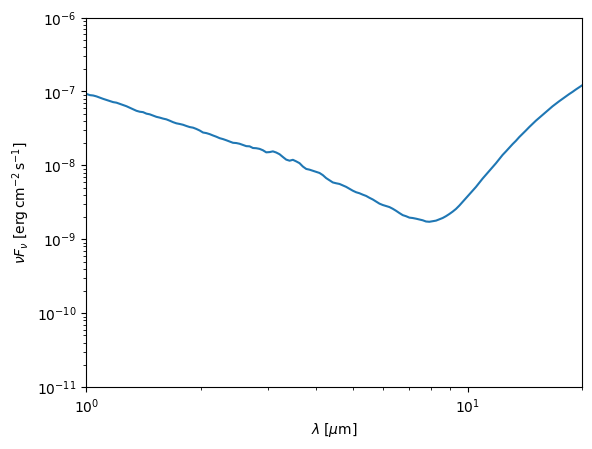

tro90
  
      WELCOME TO RADMC-3D: A 3-D CONTINUUM AND LINE RT SOLVER    
                                                                 
                          VERSION 2.0                            
                                                                 
                (c) 2008-2023 Cornelis Dullemond                 
                                                                 
       Please feel free to ask questions. Also please report     
        bugs and/or suspicious behavior without hestitation.     
      The reliability of this code depends on your vigilance!    
                    dullemond@uni-heidelberg.de                  
                                                                 
   To keep up-to-date with bug-alarms and bugfixes, follow the   
                     RADMC-3D code on github                     
             https://github.com/dullemond/radmc3d-2.0            
                                                                 
 

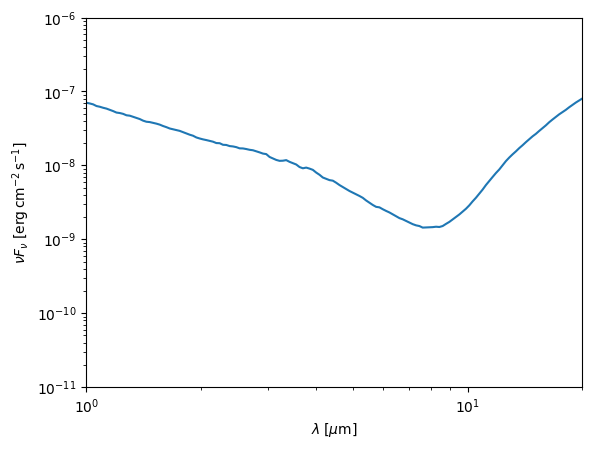

tro80
  
      WELCOME TO RADMC-3D: A 3-D CONTINUUM AND LINE RT SOLVER    
                                                                 
                          VERSION 2.0                            
                                                                 
                (c) 2008-2023 Cornelis Dullemond                 
                                                                 
       Please feel free to ask questions. Also please report     
        bugs and/or suspicious behavior without hestitation.     
      The reliability of this code depends on your vigilance!    
                    dullemond@uni-heidelberg.de                  
                                                                 
   To keep up-to-date with bug-alarms and bugfixes, follow the   
                     RADMC-3D code on github                     
             https://github.com/dullemond/radmc3d-2.0            
                                                                 
 

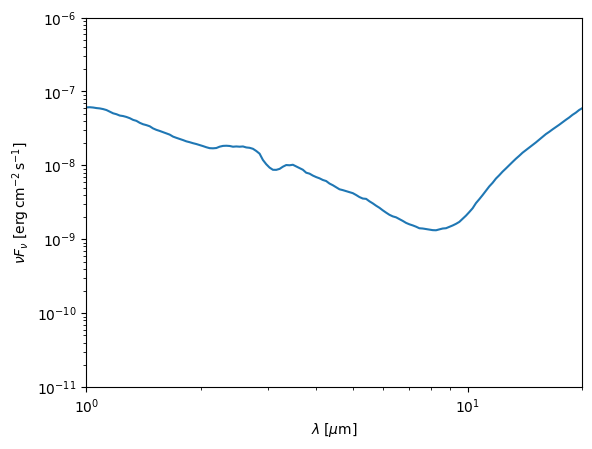

tro70
  
      WELCOME TO RADMC-3D: A 3-D CONTINUUM AND LINE RT SOLVER    
                                                                 
                          VERSION 2.0                            
                                                                 
                (c) 2008-2023 Cornelis Dullemond                 
                                                                 
       Please feel free to ask questions. Also please report     
        bugs and/or suspicious behavior without hestitation.     
      The reliability of this code depends on your vigilance!    
                    dullemond@uni-heidelberg.de                  
                                                                 
   To keep up-to-date with bug-alarms and bugfixes, follow the   
                     RADMC-3D code on github                     
             https://github.com/dullemond/radmc3d-2.0            
                                                                 
 

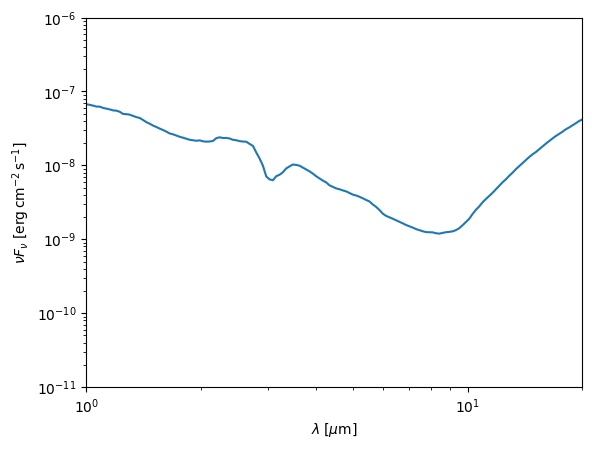

tro60
  
      WELCOME TO RADMC-3D: A 3-D CONTINUUM AND LINE RT SOLVER    
                                                                 
                          VERSION 2.0                            
                                                                 
                (c) 2008-2023 Cornelis Dullemond                 
                                                                 
       Please feel free to ask questions. Also please report     
        bugs and/or suspicious behavior without hestitation.     
      The reliability of this code depends on your vigilance!    
                    dullemond@uni-heidelberg.de                  
                                                                 
   To keep up-to-date with bug-alarms and bugfixes, follow the   
                     RADMC-3D code on github                     
             https://github.com/dullemond/radmc3d-2.0            
                                                                 
 

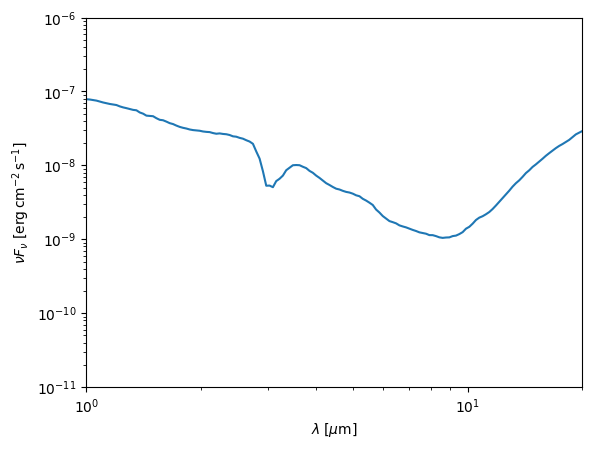

tro50
  
      WELCOME TO RADMC-3D: A 3-D CONTINUUM AND LINE RT SOLVER    
                                                                 
                          VERSION 2.0                            
                                                                 
                (c) 2008-2023 Cornelis Dullemond                 
                                                                 
       Please feel free to ask questions. Also please report     
        bugs and/or suspicious behavior without hestitation.     
      The reliability of this code depends on your vigilance!    
                    dullemond@uni-heidelberg.de                  
                                                                 
   To keep up-to-date with bug-alarms and bugfixes, follow the   
                     RADMC-3D code on github                     
             https://github.com/dullemond/radmc3d-2.0            
                                                                 
 

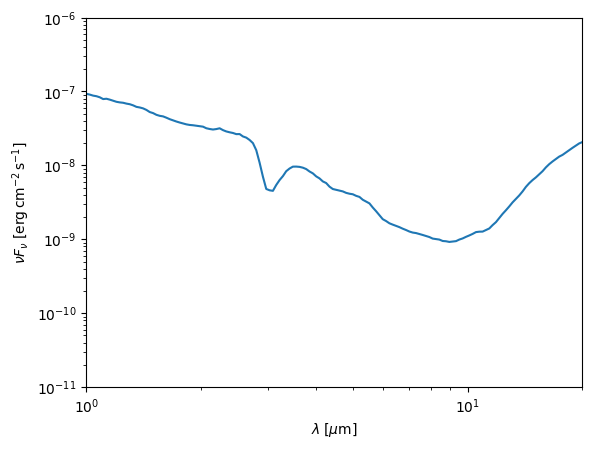

tro40
  
      WELCOME TO RADMC-3D: A 3-D CONTINUUM AND LINE RT SOLVER    
                                                                 
                          VERSION 2.0                            
                                                                 
                (c) 2008-2023 Cornelis Dullemond                 
                                                                 
       Please feel free to ask questions. Also please report     
        bugs and/or suspicious behavior without hestitation.     
      The reliability of this code depends on your vigilance!    
                    dullemond@uni-heidelberg.de                  
                                                                 
   To keep up-to-date with bug-alarms and bugfixes, follow the   
                     RADMC-3D code on github                     
             https://github.com/dullemond/radmc3d-2.0            
                                                                 
 

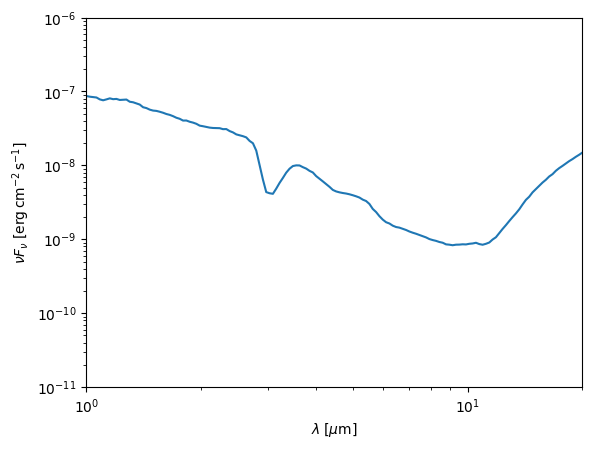

tro30
  
      WELCOME TO RADMC-3D: A 3-D CONTINUUM AND LINE RT SOLVER    
                                                                 
                          VERSION 2.0                            
                                                                 
                (c) 2008-2023 Cornelis Dullemond                 
                                                                 
       Please feel free to ask questions. Also please report     
        bugs and/or suspicious behavior without hestitation.     
      The reliability of this code depends on your vigilance!    
                    dullemond@uni-heidelberg.de                  
                                                                 
   To keep up-to-date with bug-alarms and bugfixes, follow the   
                     RADMC-3D code on github                     
             https://github.com/dullemond/radmc3d-2.0            
                                                                 
 

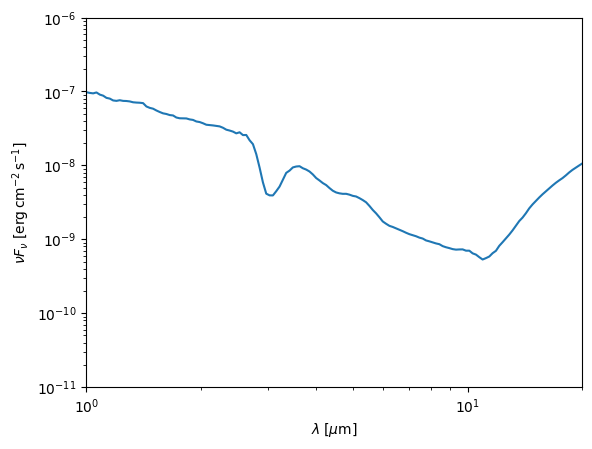

tro20
  
      WELCOME TO RADMC-3D: A 3-D CONTINUUM AND LINE RT SOLVER    
                                                                 
                          VERSION 2.0                            
                                                                 
                (c) 2008-2023 Cornelis Dullemond                 
                                                                 
       Please feel free to ask questions. Also please report     
        bugs and/or suspicious behavior without hestitation.     
      The reliability of this code depends on your vigilance!    
                    dullemond@uni-heidelberg.de                  
                                                                 
   To keep up-to-date with bug-alarms and bugfixes, follow the   
                     RADMC-3D code on github                     
             https://github.com/dullemond/radmc3d-2.0            
                                                                 
 

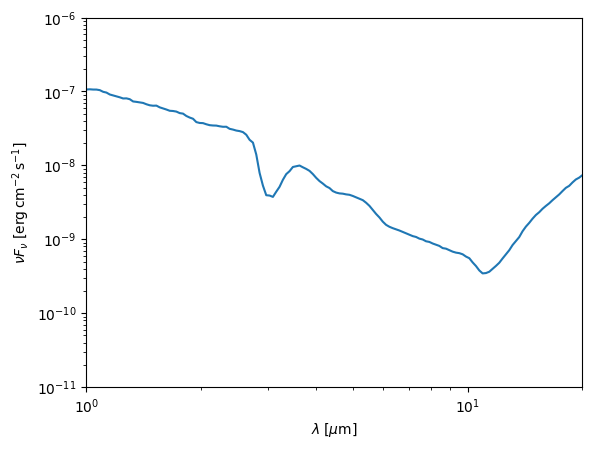

tro10
  
      WELCOME TO RADMC-3D: A 3-D CONTINUUM AND LINE RT SOLVER    
                                                                 
                          VERSION 2.0                            
                                                                 
                (c) 2008-2023 Cornelis Dullemond                 
                                                                 
       Please feel free to ask questions. Also please report     
        bugs and/or suspicious behavior without hestitation.     
      The reliability of this code depends on your vigilance!    
                    dullemond@uni-heidelberg.de                  
                                                                 
   To keep up-to-date with bug-alarms and bugfixes, follow the   
                     RADMC-3D code on github                     
             https://github.com/dullemond/radmc3d-2.0            
                                                                 
 

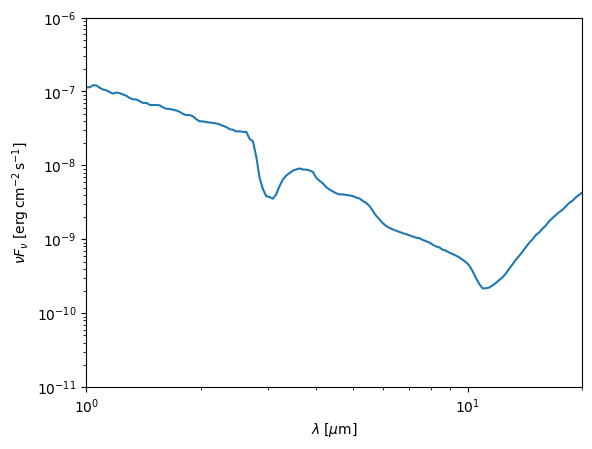

In [15]:
chem = input('input species name')
name = [f'{chem}100', f'{chem}90', f'{chem}80', f'{chem}70', f'{chem}60', f'{chem}50', f'{chem}40', f'{chem}30', f'{chem}20', f'{chem}10']
for i in range(0,10):
    diagnosis(name[i])